In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from src.utils.data_utils import load_country_bias_data

In [3]:
df_ratings_locs = load_country_bias_data('data/BeerAdvocate/')
# Separate into users that rated beers from their country or US state and users that rated beers from somewhere else
df_domestic_rating = df_ratings_locs[df_ratings_locs.user_location == df_ratings_locs.beer_location]
df_international_rating = df_ratings_locs[df_ratings_locs.user_location != df_ratings_locs.beer_location]

# Drop users that are in both sets so we can suppose the two sets independent
overlap_users = set(df_domestic_rating.user_id).intersection(set(df_international_rating.user_id))
df_domestic_rating = df_domestic_rating[df_domestic_rating.user_id.isin(overlap_users)]
df_international_rating = df_international_rating[df_international_rating.user_id.isin(overlap_users)]

# Counts how many ratings a beer has and merge this count to each beer rating
df_domestic_counts = df_domestic_rating.groupby('beer_id')['beer_name'].count().rename('rating_count')
df_international_counts = df_international_rating.groupby('beer_id')['beer_name'].count().rename('rating_count')
df_domestic_rating = df_domestic_rating.merge(right=df_domestic_counts, on='beer_id', how='left')
df_international_rating = df_international_rating.merge(right=df_international_counts, on='beer_id', how='left')

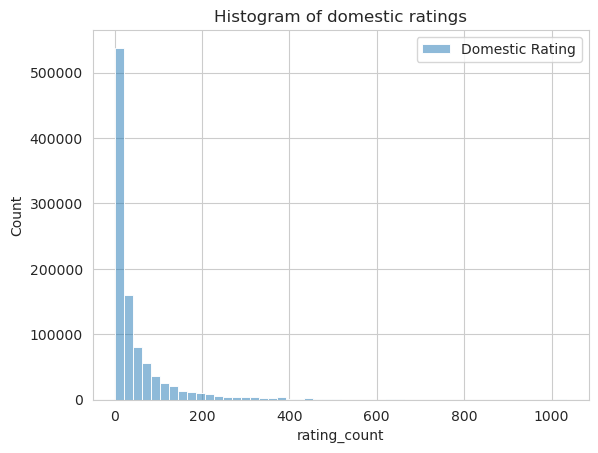

In [4]:
sns.histplot(df_domestic_rating.rating_count, bins=50, alpha=0.5, label='Domestic Rating')
plt.title('Histogram of domestic ratings')
plt.legend()

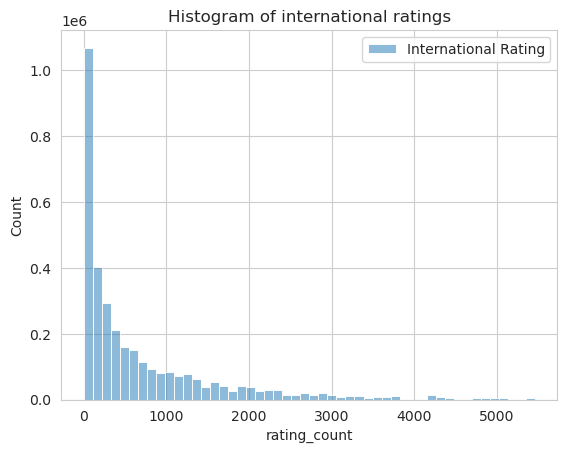

In [5]:
sns.histplot(df_international_rating.rating_count, bins=50, alpha=0.5, label='International Rating')
plt.title('Histogram of international ratings')
plt.legend()

In [6]:
# Find quantile for the rating count in both sets to have a threshold to remove beers with too few ratings
perc = 0.25
dom_thresh = df_domestic_rating.rating_count.quantile(perc)
inter_thresh = df_international_rating.rating_count.quantile(perc)
print(f'{100 * perc}% quantile of domestic ratings counts: {dom_thresh}')
print(f'{100 * perc}% quantile of international ratings counts: {inter_thresh}')
thresh = min(dom_thresh, inter_thresh)

# Remove beers that have less than 'thresh' ratings
df_dom_filtered = df_domestic_rating[df_domestic_rating.rating_count > thresh]
df_inter_filtered = df_international_rating[df_international_rating.rating_count > thresh]
print(f"Size of domestic ratings: {len(df_dom_filtered['beer_id'])}")
print(f"Size of international ratings: {len(df_inter_filtered['beer_id'])}")

25.0% quantile of domestic ratings counts: 5.0
25.0% quantile of international ratings counts: 69.0
Size of domestic ratings: 741535
Size of international ratings: 3200492


Mean rating for the domestic ratings: 3.9428210940818706
Mean rating for the international ratings: 3.8980626447433737
Standard deviation of rating for the domestic ratings: 0.5231940742341481
Standard deviation of rating for the international ratings: 0.568577583767427


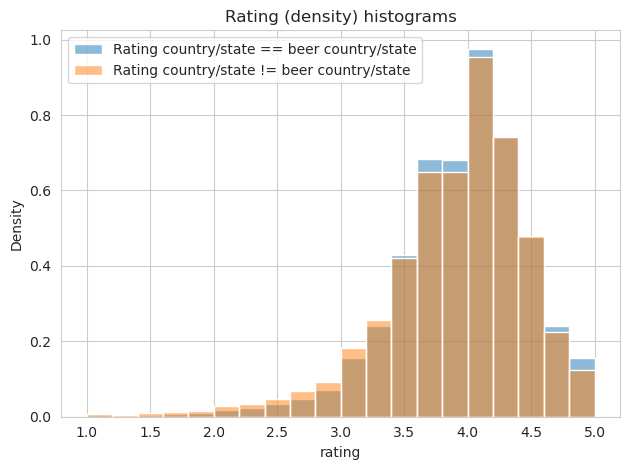

In [7]:
# Plot the densities histograms of the ratings for both domestic and international ratings
sns.histplot(df_dom_filtered['rating'], stat='density', bins=20, alpha=0.5,
             label='Rating country/state == beer country/state')
sns.histplot(df_inter_filtered['rating'], stat='density', bins=20, alpha=0.5,
             label='Rating country/state != beer country/state')
plt.title('Rating (density) histograms')
plt.tight_layout()
plt.legend()

print(f"Mean rating for the domestic ratings: {df_dom_filtered['rating'].mean()}")
print(f"Mean rating for the international ratings: {df_inter_filtered['rating'].mean()}")
print(f"Standard deviation of rating for the domestic ratings: {df_dom_filtered['rating'].std()}")
print(f"Standard deviation of rating for the international ratings: {df_inter_filtered['rating'].std()}")

In [8]:
# The distributions are more or less normal, and we suppose they are independent so we can use the two samples t-test
# H0: There is no significant difference between domestic and international ratings
# H1: There is a significant difference between domestic and international ratings

p_value = stats.ttest_ind(df_dom_filtered['rating'], df_inter_filtered['rating']).pvalue
print(f'P-value: {p_value}')

# If the p-value is smaller than significance level 5% we reject H0
if p_value < 0.05:
    print("There is a significant difference between domestic and international ratings")
else:
    print("There is no significant difference between domestic and international ratings")

P-value: 0.0
There is a significant difference between domestic and international ratings
